# Initialization

## Importing VPython

Import the class vector from vpythons module visual (or in this case vpython which is used for this notebook)

In [1]:
from vpython import vector

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Setting up the Problem

Definition of parameters

In [2]:
rM0 = 4.6    # in units of R0 
vM0 = 0.51   # in units of R0/T0
aM  = 0.99   # in units of R0/T0**2 
T   = 88.    # in units of T0
rS  = 3.e-7  # in units of R0

Initialize distance and velocity vectors

In [3]:
vec_rM0 = vector(0, rM0, 0)
vec_vM0 = vector(vM0, 0, 0)

Definition of the time step

In [5]:
dt = 2 * vM0 / aM / 5000

Define a function for the time evolution

In [6]:
def evolve_mercury(vec_rM_old, vec_vM_old, alpha, dt=dt):
    # Compute the strength of the acceleration
    aMS = aM * ( 1 + alpha * rS / vec_rM_old.mag  ) / vec_rM_old.mag**2
    # Multiply by the direction
    vec_aMS = - aMS * ( vec_rM_old / vec_rM_old.mag )
    # Update velocity vector
    vec_vM_new = vec_vM_old + vec_aMS * dt
    # Update position vector
    vec_rM_new = vec_rM_old + vec_vM_new * dt
    # Return the new vectors
    return vec_rM_new, vec_vM_new

# Graphical Representation

## Define the Objects

Define the initial coordinates; M = mercury, S = sun ...

... and the initial velocities.

Add a visible trajectory to mercury

# Computation

## Farm $\delta \theta$

In [7]:
import numpy as np
import pandas as pd

In [9]:
alphas = np.linspace(0, 1.e4, 11)
dt0    = 2 * vM0 / aM
dts    = dt0 / 100 / np.array([1,2,5,10,20,50])

In [45]:
data = []

TMax = T*10.2


for alpha in alphas:
    for dt in dts:
        
        vec_rM = vec_rM0
        vec_vM = vec_vM0
        
        rprev  = [vec_rM0/3, vec_rM0/2, vec_rM0]
        
        t     = 0
        turn  = 0
    
        while t < TMax:
            vec_rM, vec_vM = evolve_mercury(vec_rM, vec_vM, alpha, dt=dt)
            rprev.pop(0)
            rprev.append(vec_rM)
            
            if rprev[0].mag > rprev[1].mag and rprev[1].mag < rprev[2].mag:
                dtheta = np.arccos( rprev[1].y /  rprev[1].mag )/2/np.pi*360
                data.append({
                    #"dt"     : dt,
                    "alpha"  : alpha,
                    "dtfact" : dt0/dt,
                    "turn"   : turn,
                    "dtheta" : dtheta,
                    "t"      : t
                })
                turn += 1
        
            t = t + dt

frame = pd.DataFrame(data)
#frame.set_index(["alpha","dtfact"], inplace=True)
print frame.shape
frame.head()

In [46]:
print frame.shape
frame.head()

(726, 5)


,alpha,dtfact,dtheta,t,turn
0,0.0,100.0,0.130897,0.020606,0
1,0.0,100.0,0.126498,88.503030,1
2,0.0,100.0,0.187548,176.995758,2
3,0.0,100.0,0.183149,265.478182,3
4,0.0,100.0,0.178750,353.960606,4


In [47]:
frame.to_csv("mercury_shift.dat")

## Plotting

In [61]:
import seaborn as sns
sns.set(style="whitegrid", font="Source Sans Pro", font_scale=1.4)

### Zero Precession

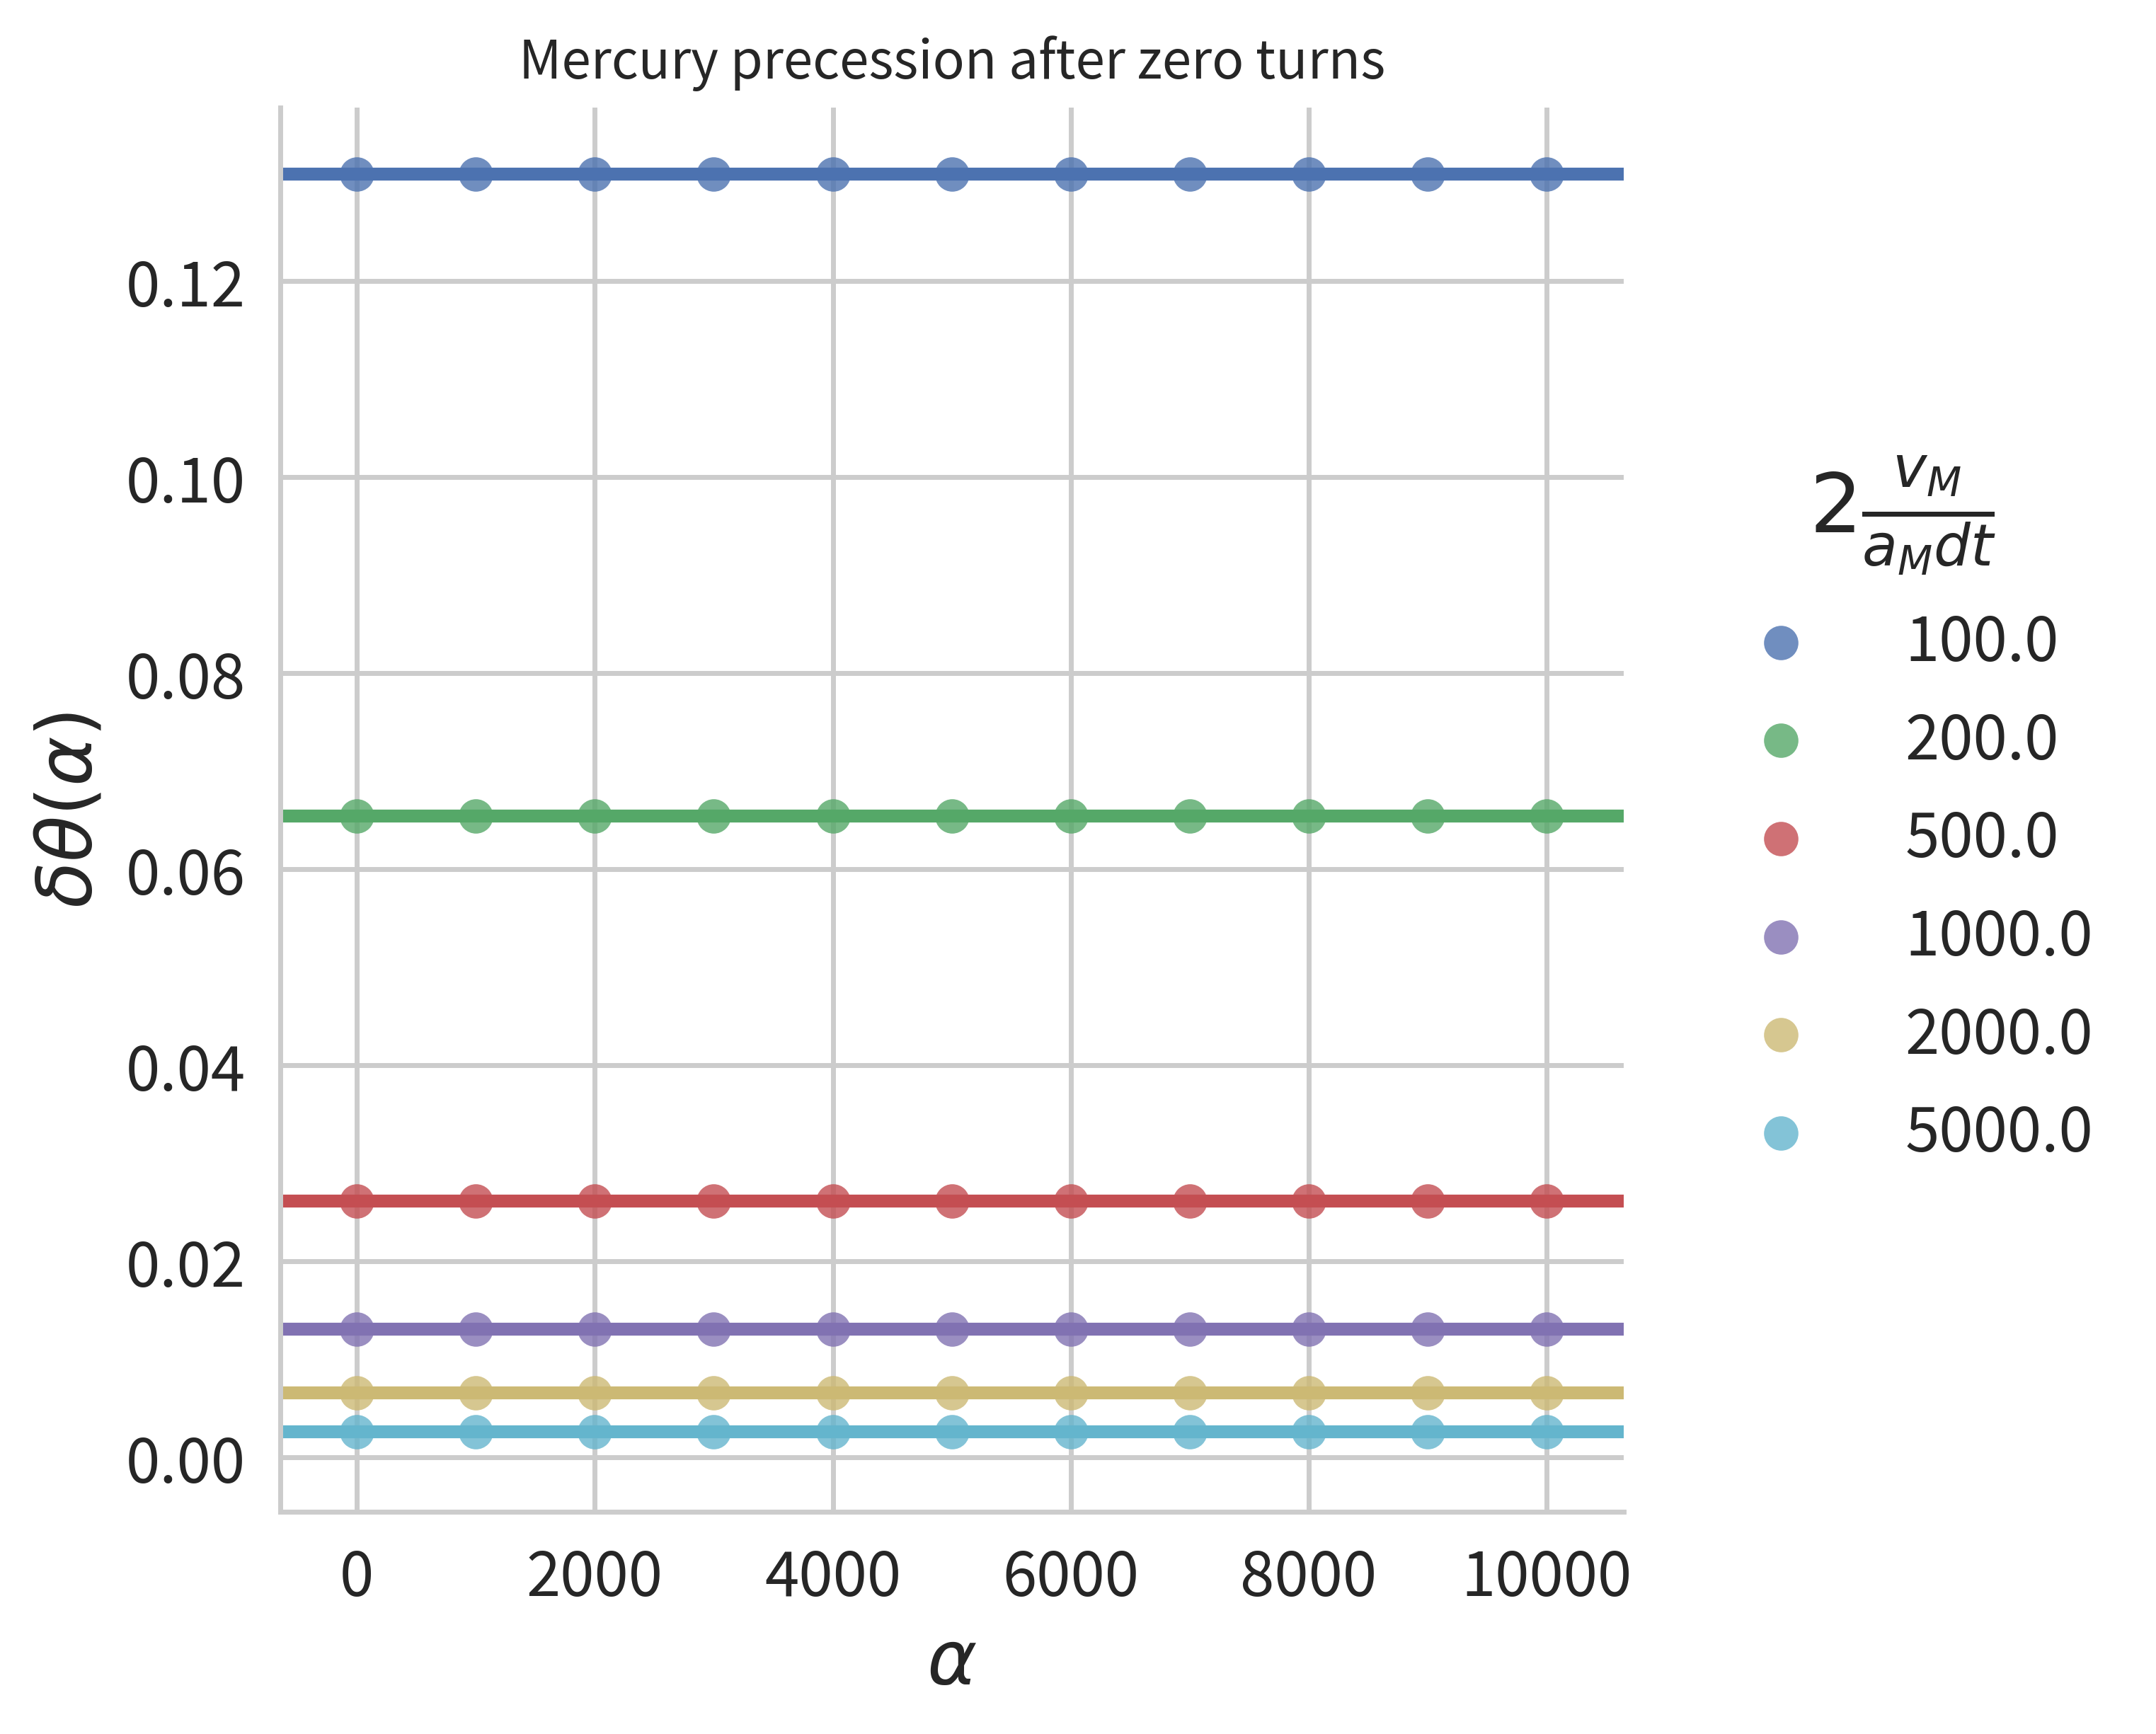

In [92]:
tf = frame.query("turn == 0")

graph = sns.lmplot(data=tf, hue="dtfact", y="dtheta", x="alpha", legend=False)

graph.fig.set_dpi(500)
graph.fig.set_size_inches(5,5)

graph.set_axis_labels(r"$\alpha$",r"$\delta\theta(\alpha)$")
ax = graph.fig.gca()
ax.set_title("Mercury precession after zero turns", fontdict={"size": 12})

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), title=r"$2\frac{v_M}{a_M dt}$")


sns.plt.show(graph)

In [93]:
graph.savefig("initial_time_shift.pdf", bbox_inches="tight")

### Angular Growth

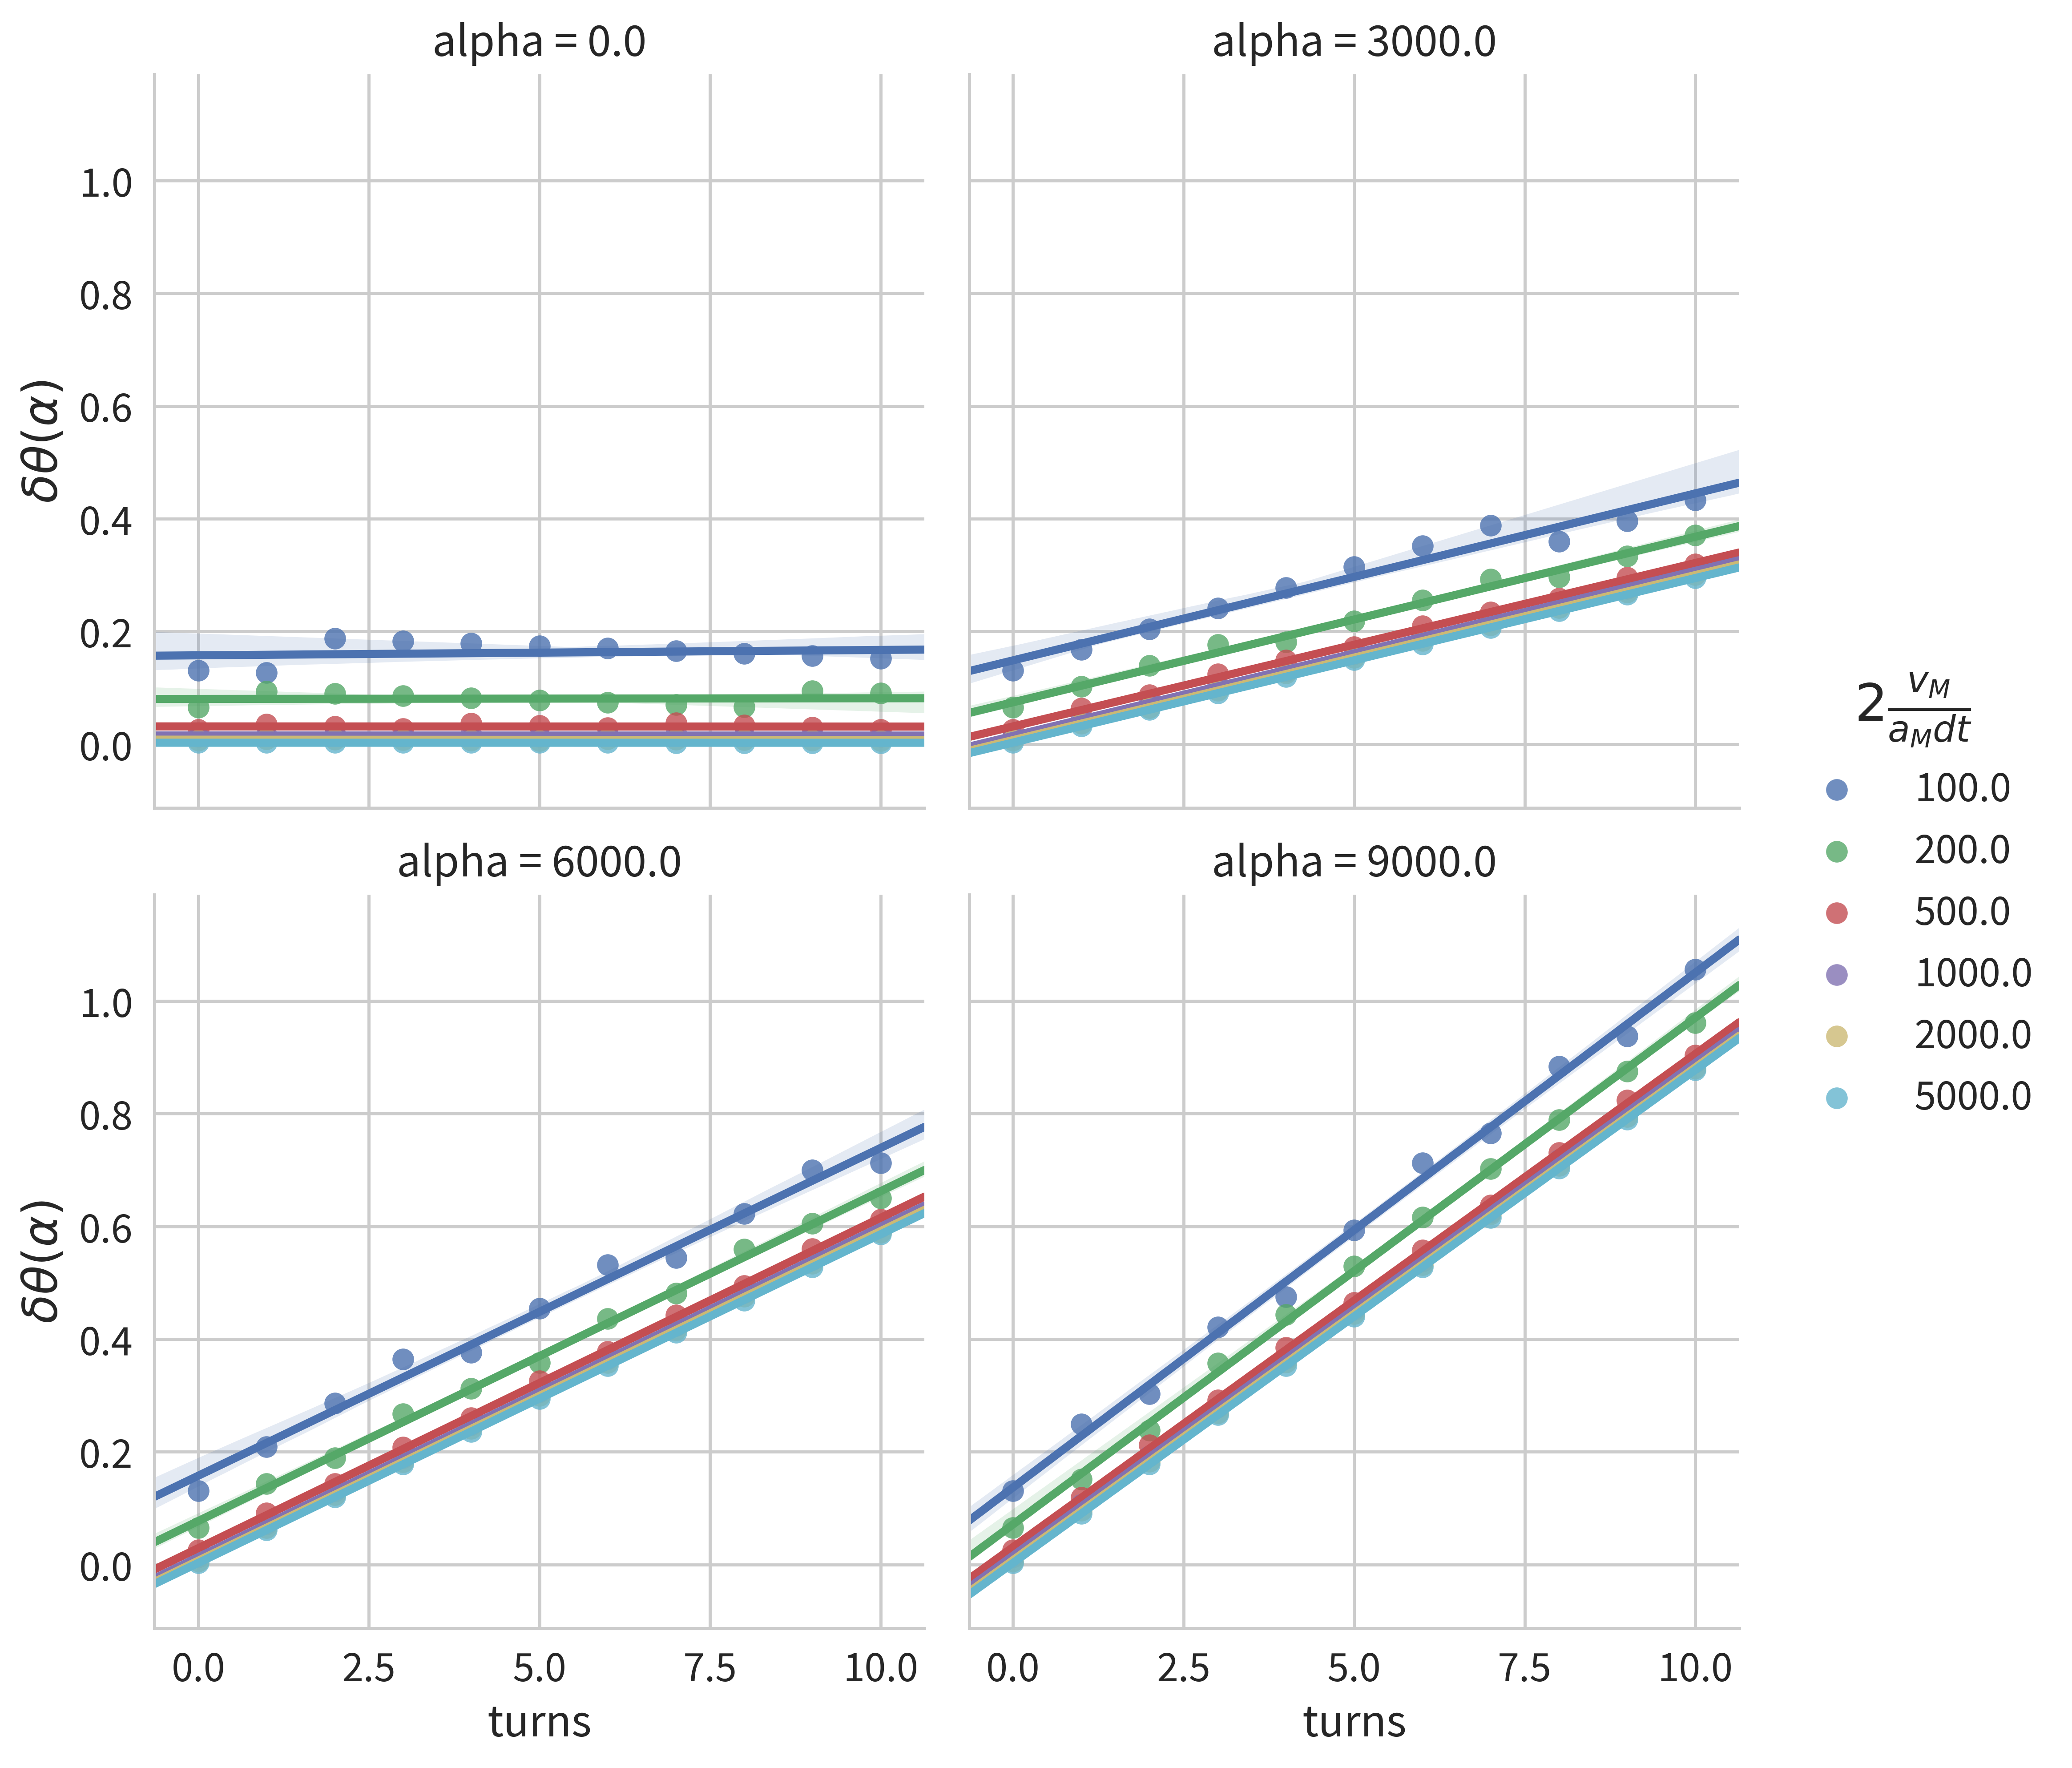

In [113]:
query = " or ".join(["alpha == {0}".format(el) for el in frame.alpha.unique()[::3]])
tf = frame.query(query)

graph = sns.lmplot(data=tf, x="turn", y="dtheta", hue="dtfact", legend=False, col="alpha", col_wrap=2)

graph.fig.set_dpi(500)
graph.fig.set_size_inches(8,8)

graph.set_axis_labels(r"turns",r"$\delta\theta(\alpha)$")
ax = graph.fig.gca()
#ax.set_title("Mercury precession after zero turns", fontdict={"size": 12})

ax.legend(loc="center left", bbox_to_anchor=(1.02, 1.), title=r"$2\frac{v_M}{a_M dt}$")


sns.plt.show(graph)

In [114]:
graph.savefig("precession_growth.pdf", bbox_inches="tight")

# Old

## Plotting

In [355]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import re

sns.set(style="whitegrid", font="Source Sans Prop", font_scale=1.4)

Execute the loop as long as t < T

In [339]:
res = {}

for alpha in np.linspace(0, 1.e4, 11):
    t      = 0
    
    print alpha

    vec_rM = vec_rM0
    vec_vM = vec_vM0

    xpos = []
    ypos = []
    vx   = []
    vy   = []
    turns= []

    turn = 0
    theta = []
    while t < T*10.2:
        vec_rM, vec_vM = evolve_mercury(vec_rM, vec_vM, alpha)
        xpos.append(vec_rM.x)
        ypos.append(vec_rM.y)
        vx.append(vec_vM.x)
        vy.append(vec_vM.y)
        turns.append(turn)
        if len(xpos)>4:
              if xpos[-3]**2 + ypos[-3]**2 >= xpos[-2]**2 + ypos[-2]**2 <= xpos[-1]**2 + ypos[-1]**2:
                    turn += 1
                    theta.append(np.arccos( ypos[-2] /  np.sqrt(xpos[-2]**2 + ypos[-2]**2) )/turn/2/np.pi*360)
                    turns[-3] = turns[-2] = turns[-1] = turn

        t = t + dt
    res[alpha] = theta

turns = np.array(turns)
xpos = np.array(xpos)
ypos = np.array(ypos)
vx = np.array(vx)
vy = np.array(vy)

0.0
1000.0
2000.0
3000.0
4000.0
5000.0
6000.0
7000.0
8000.0
9000.0
10000.0


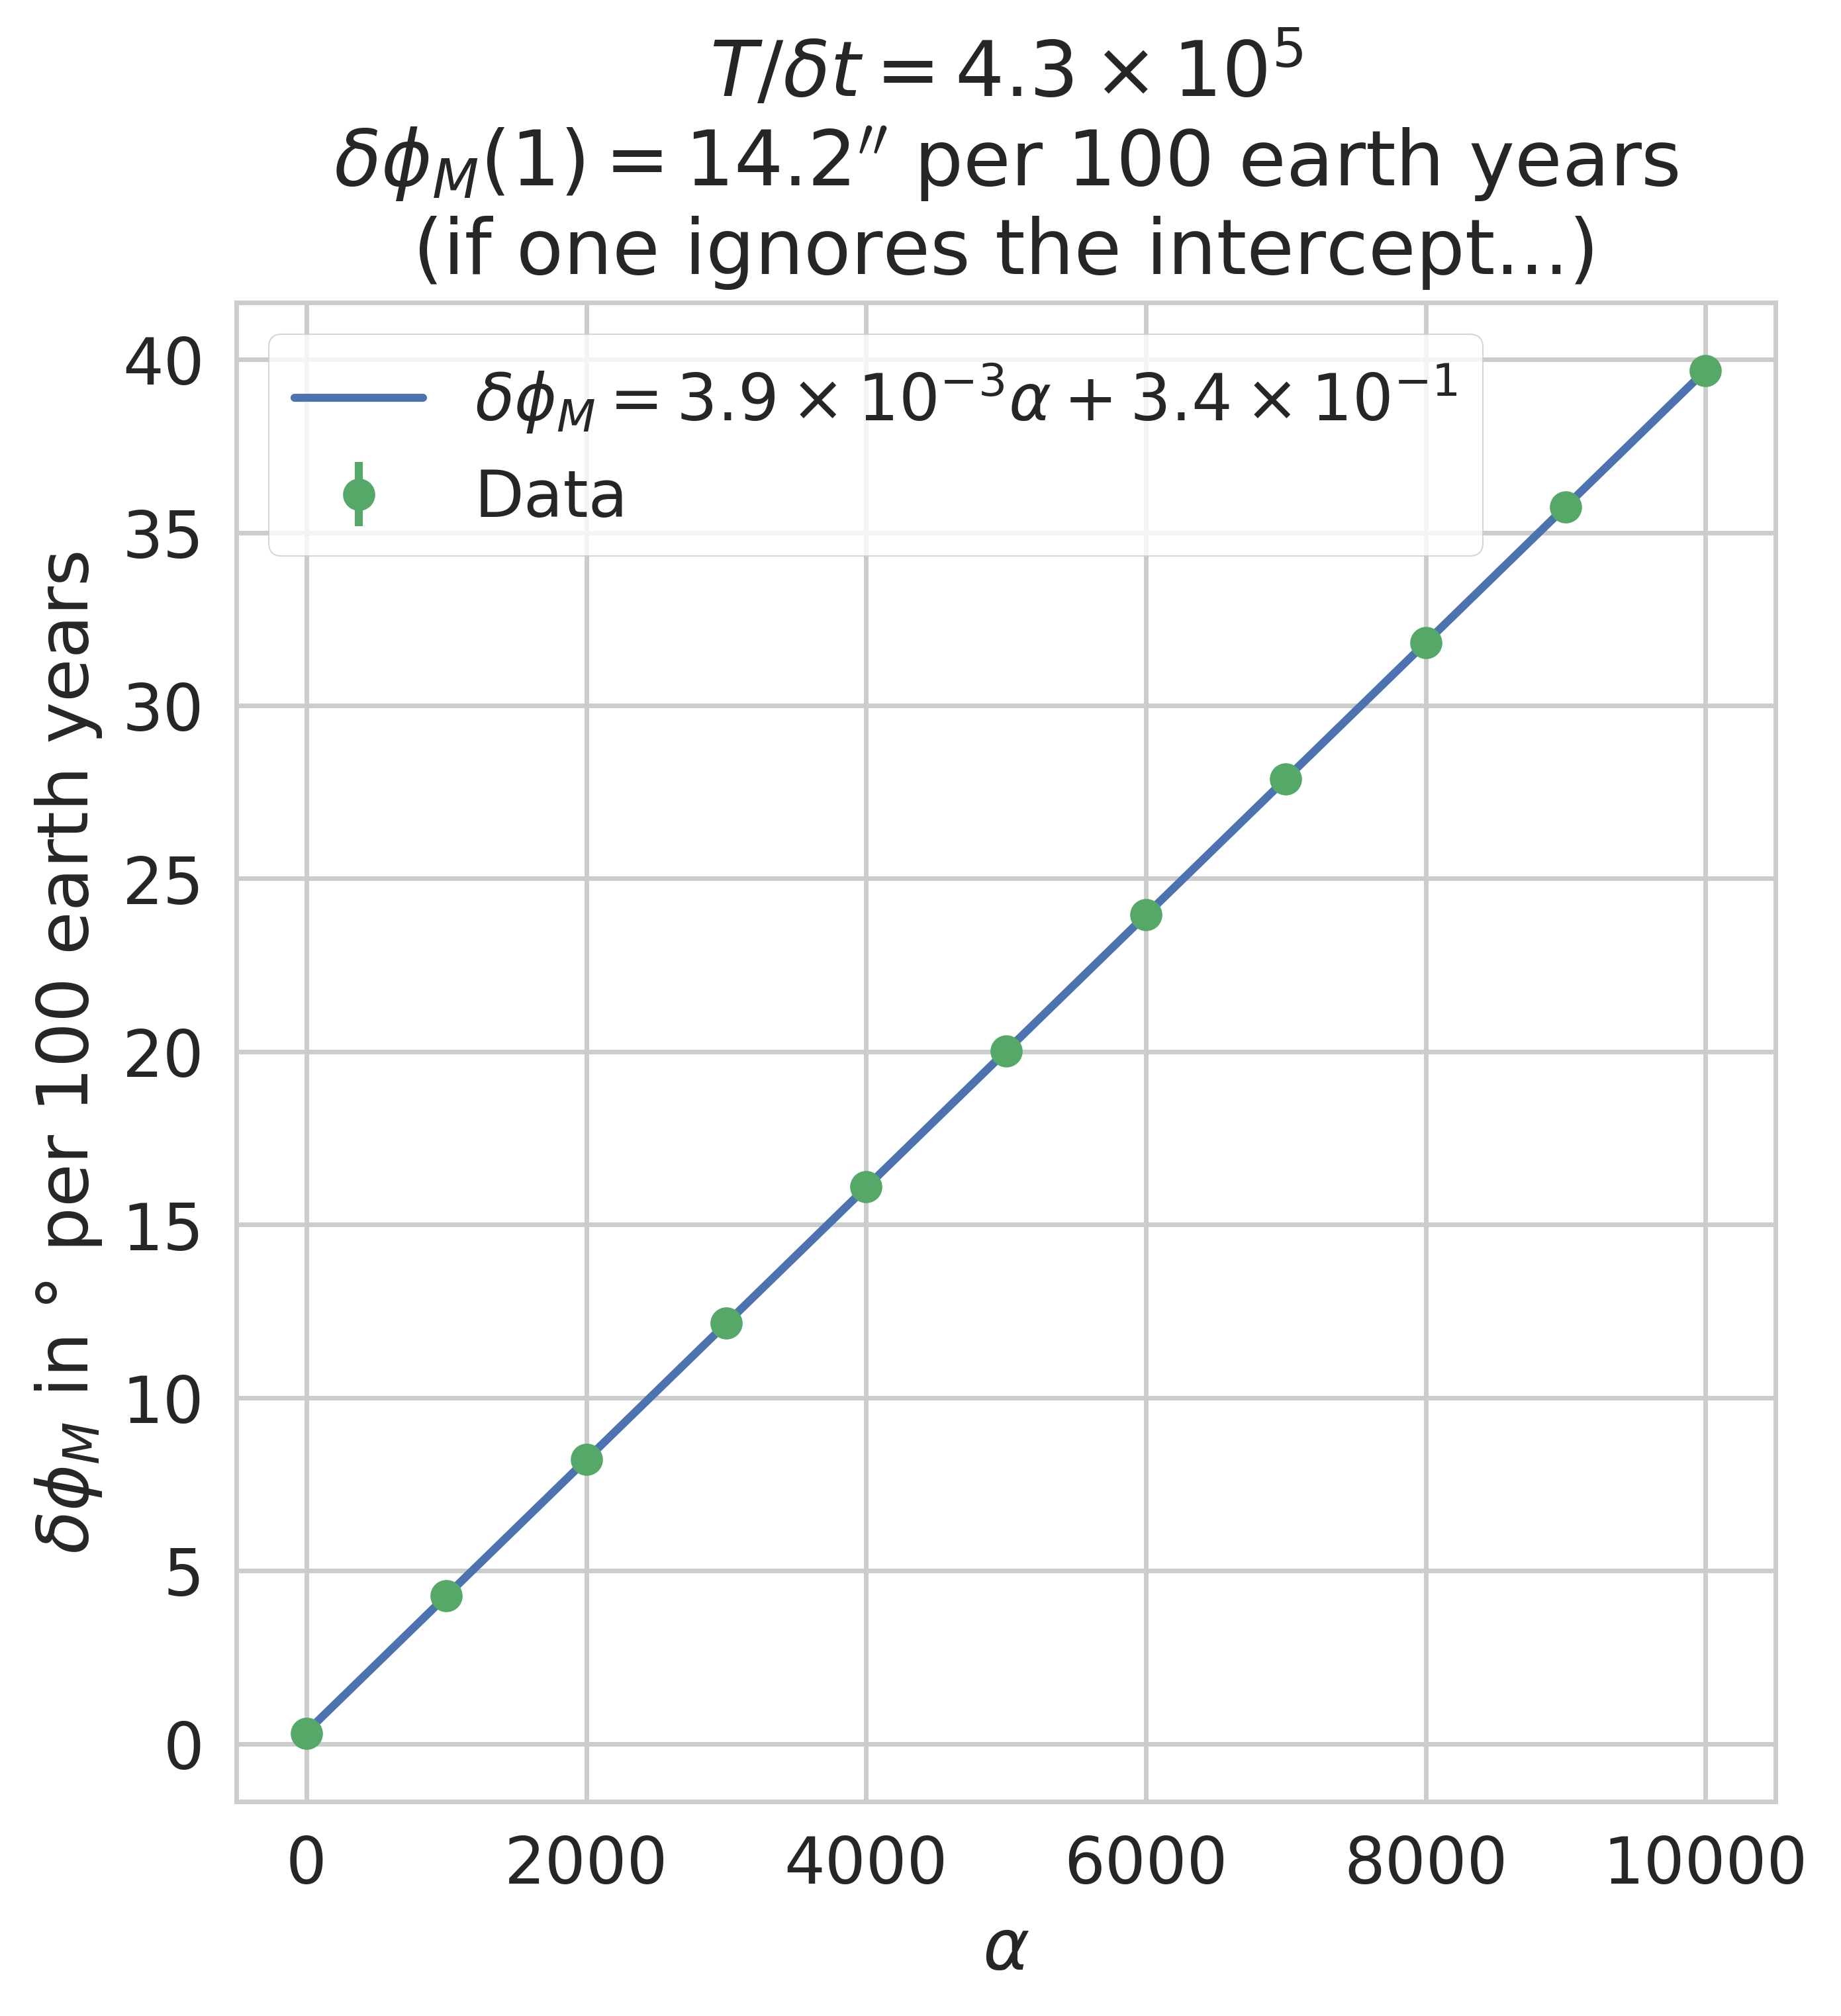

In [391]:
fig = sns.plt.figure(dpi=500, figsize=(6,6))

ax = fig.gca()

x, y = res.keys(), np.average(res.values(), axis=1)*356./88*100
dely = np.std(res.values(), axis=1)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)



xl = np.linspace(0, 1.e4, 200)

label = r"$\delta \phi _M = {m:1.1e}\alpha + {b:1.1e} $".format(m=slope, b=intercept).replace("0","")
label = re.sub(r"e([\+\-0-9]+)",r"\\times 10^{{\g<1>}}", label)

ax.plot(xl, intercept+slope*xl, label=label)
ax.errorbar(x, y, yerr=dely, marker="o", linestyle="None", label="Data")

sns.plt.legend(frameon=True, loc="upper left")

ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(u"$\delta \phi _M$ in ° per 100 earth years")

title = ("$T / \delta t = {0:1.1e}$"+\
        "\n$\delta \phi _M(1) = {1:1.1f}''$ per 100 earth years").format(T/dt, slope*3600).replace("+0","") +\
        "\n(if one ignores the intercept...)"
title = re.sub(r"e([\+\-0-9]+)",r"\\times 10^{{\g<1>}}", title)

ax.set_title(title)

sns.plt.show()

In [392]:
fig.savefig("alpha_interpolation.pdf", bbox_inches="tight")

In [390]:
!open alpha_interpolation.pdf

In [326]:
r   = np.sqrt(np.array(xpos)**2 + np.array(ypos)**2)
phi = np.arccos( rM0*ypos / rM0 / r )
phi[xpos < 0] = - phi[xpos < 0] + 2*np.pi

In [262]:
for nel, el in enumerate(phi[1:]):
    if abs(el + 2*np.pi - phi[nel]) < abs(el - phi[nel]):
        phi[nel+1:] += 2*np.pi
        print nel+1, phi[nel+1]

74713 6.28321369688
149416 12.5664827297
224095 18.849638476
298739 25.1327482228
373338 31.4159839071
447879 37.6991877843
522350 43.9822996048
596742 50.2655033204
671044 56.5486968255
745248 62.831926237
819346 69.1150590918


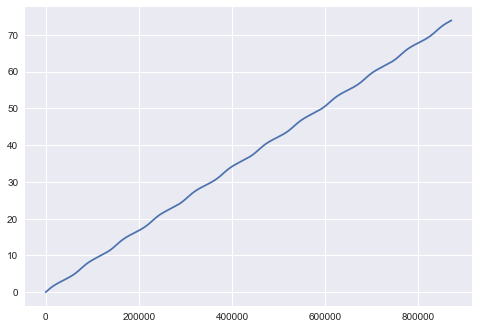

In [255]:
sns.plt.plot(phi)
sns.plt.show()

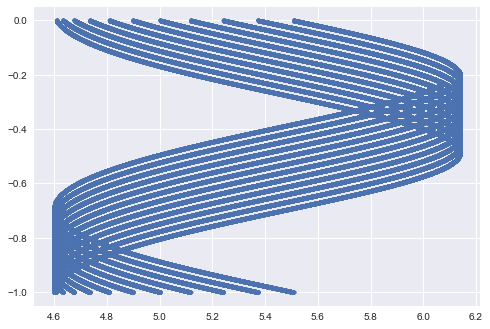

In [246]:
sns.plt.plot(r, phi/2/np.pi - 1. , ".")
sns.plt.show()

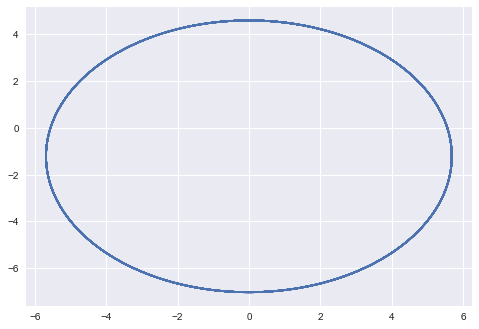

In [228]:
sns.plt.plot(xpos, ypos, "-")
sns.plt.show()

In [67]:
(xpos < 0).shape
(ypos < 0).shape
np.logical_and(xpos < 0, ypos < 0).shape

(854118,)